# Import all Libs

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from keras.layers import Input,Dense,Conv2D,MaxPooling2D,UpSampling2D
#from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.optimizers import RMSprop
import os
from tensorflow.keras.layers import (
    BatchNormalization, SeparableConv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
)

# Count no of files

In [ ]:
# folder path
dir_path = r'bone-shadow-supression/BB/augmented/augmented/source'
count = 0
# Iterate directory
for path in os.listdir(dir_path):
    # check if current path is a file
    if os.path.isfile(os.path.join(dir_path, path)):
        count += 1
print('File count:', count)

# Data preprocessing

In [ ]:
no_of_images = 4080
img_size = (224,224)
imgs_source = []
imgs_target = []

dir_source = "bone-shadow-supression/BB/augmented/augmented/source"
dir_target = "bone-shadow-supression/BB/augmented/augmented/target"

i = 0
for _, _, filenames in os.walk('bone-shadow-supression/BB/augmented/augmented/source/'):
    for filename in filenames:
        print(i)
        i = i+1
        if(i > no_of_images):
            break
        img_source = cv2.imread(os.path.join(dir_source,filename),cv2.IMREAD_GRAYSCALE)
        img_target = cv2.imread(os.path.join(dir_target, filename),cv2.IMREAD_GRAYSCALE)
        # resizing images
        img_source = cv2.resize(img_source,img_size)
        img_target = cv2.resize(img_target,img_size)
        # normalizing images
        img_source = np.array(img_source)/255
        img_target = np.array(img_target)/255

        imgs_source.append(img_source)
        imgs_target.append(img_target)


In [ ]:
print(len(imgs_source))
print(len(imgs_target))

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(imgs_source[1],cmap='gray')
plt.gray()

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(imgs_target[1])
plt.gray()

In [ ]:
plt.figure(figsize=(15,10))

for i in range(3):
    ax = plt.subplot(2, 3, i+1)
    plt.imshow(imgs_source[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title('Source')

    ax = plt.subplot(2, 3, i+4)
    plt.imshow(imgs_target[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title('Target')
plt.show()

## Slit to train-test

In [ ]:
img_rows = 224
img_cols = 224
img_channels = 1
img_shape = (img_rows, img_cols, img_channels)

source = np.array(imgs_source).reshape(-1, img_rows, img_cols, img_channels)
target = np.array(imgs_target).reshape(-1, img_rows, img_cols, img_channels)

source_train, source_test, target_train, target_test = train_test_split(source, target,
                                                                        test_size=0.20,
                                                                        random_state=1)

In [ ]:
print(source_train.shape, source_test.shape, target_train.shape, target_test.shape)

# Create AutoEncoder Model

In [ ]:
def autoencoder(input_img):
    #encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(48, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(48, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)


    #decoder
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    up1 = UpSampling2D((2,2))(conv4)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    up2 = UpSampling2D((2,2))(conv5)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2)
    return decoded

In [ ]:
img_shape

In [ ]:
input_img = Input(shape = img_shape)
autoencoder = Model(input_img, autoencoder(input_img))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop() ,metrics=["mae","mse"])

In [ ]:
autoencoder.summary()

# Model Fit

In [ ]:
n_epoch = 50
n_batch = 32
autoencoder_train = autoencoder.fit(source_train, target_train,
                                    epochs = n_epoch,
                                    batch_size = n_batch,
                                    verbose = 1,
                                    validation_data = (source_test, target_test))

In [ ]:
interval_epochs = [0, 49]
for e in interval_epochs:
    print("epoch = {}\tLoss = {:.5f}\tValidation_Loss = {:.5f}".format(e+1,autoencoder_train.history['loss'][e],autoencoder_train.history['val_loss'][e]))

# Results

In [ ]:
n = np.arange(0, n_epoch)
plt.figure()
plt.plot(n, autoencoder_train.history['loss'], label = 'Training Loss')
plt.plot(n, autoencoder_train.history['val_loss'], label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [ ]:
n = np.arange(0, n_epoch)
plt.figure()
plt.plot(n, autoencoder_train.history['mae'], label = 'Training mae')
plt.plot(n, autoencoder_train.history['val_mae'], label = 'Validation mae')
plt.title('Training and Validation mae')
plt.xlabel('Epochs')
plt.ylabel('mae')
plt.legend()

In [ ]:
n = np.arange(0, n_epoch)
plt.figure()
plt.plot(n, autoencoder_train.history['mse'], label = 'Training mse')
plt.plot(n, autoencoder_train.history['val_mse'], label = 'Validation mse')
plt.title('Training and Validation mse')
plt.xlabel('Epochs')
plt.ylabel('mse')
plt.legend()

# See the prediction results

In [ ]:
source_test.shape

In [ ]:
pred = autoencoder.predict(source_test)

In [ ]:
plt.figure(figsize=(15,10))

for i in range(5):
    ax = plt.subplot(3, 5, i+1)
    plt.imshow(source_test[i].reshape(224,224))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title('Source_Test')

    ax = plt.subplot(3, 5, i+6)
    plt.imshow(pred[i].reshape(224,224))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title('Predicted')

    ax = plt.subplot(3, 5, i+11)
    plt.imshow(target_test[i].reshape(224,224))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title('Target')
plt.show()

In [ ]:
target_test.shape

# See the prediction results on NIH dataset

In [ ]:
test1 = []
test = cv2.imread('C:/Users/Rugved Chavan/Desktop/GAIP Project/cleaned_data/Pneumonia/00000591_004.png',cv2.IMREAD_GRAYSCALE)
# resizing images
test = cv2.resize(test,(224,224))
# normalizing images
test = np.array(test)/255
test1.append(test)

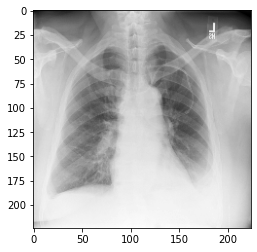

In [60]:
plt.imshow(test1[0])

In [61]:
img_rows = 224
img_cols = 224
img_channels = 1
img_shape = (img_rows, img_cols, img_channels)

test2 = np.array(test1).reshape(-1, img_rows, img_cols, img_channels)

In [62]:
test2.shape

(1, 224, 224, 1)

In [63]:
pred1 = autoencoder.predict(test2)

1/1 [==============================] - 0s 13ms/step


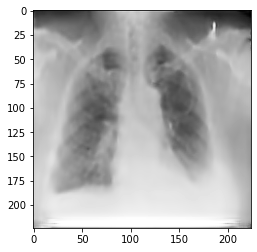

In [64]:
plt.imshow(pred1[0],  cmap='gray')
plt.imsave('results5.png',np.squeeze(pred1[0]),  cmap='gray')